# Simulating a Ring-shaped, Loosely Confined Homopolymer

Here, we simulate a ring-shaped polymer in a large, spherical confinement. We initialize the polymer as a biased Gaussian random walk, where the end of the chain is driven towards the starting bead position. The polymer is specified to be highly stiff. We expect the predicted polymer configuration to equilibrate to a loose ring, despite a relatively compact initialization.

### Setup

Install necessary modules, add the package root directory to the system path, and change working directory to root. Every simulation will involve similar setup steps.

**Do not run the setup cell more than once, except after restarting the kernel.** There is no way to consistently track the directory containing the notebook.

In [1]:
import os
import sys

# Insert package root to system path
cwd = os.getcwd()
parent_dir = cwd + "/../.."
sys.path.insert(1, parent_dir)

print("Directory containing the notebook:")
print(cwd)

Directory containing the notebook:
/Users/jwakim/Documents/Wakim_Research/Scripts/chromo_20Jan2022/doc/examples


In [2]:
# External modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Package modules
import chromo.mc as mc
from chromo.polymers import LoopedSSTWLC
import chromo.marks
from chromo.fields import UniformDensityField
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name
import chromo.util.poly_stat as ps

In [3]:
# Change working directory to package root
os.chdir(parent_dir)
print("Root Directory of Package: ")
print(os.getcwd())

Root Directory of Package: 
/Users/jwakim/Documents/Wakim_Research/Scripts/chromo_20Jan2022


### Specify Epigenetic Marks

Epigenetic marks are collectively stored in a data frame that we call the "mark collection." We can generate the mark collection using the `make_mark_collection` function in the `chromo.marks` module. The mark collection accepts as an input a list of epigenetic mark objects. Certain epigenetic mark objects are pre-implemented in the `chromo.marks` module and can be instantiated by name using the `get_by_name` method in the `chromo.marks` module.

All simulations require at least one mark to be defined, even if we want to simulate a homopolymer like here. We have defined a placeholder mark named `null_mark` which serves only to ensure compatibility with the rest of the code.

In [4]:
# Instantiate the HP1 mark, which is pre-defined in the `chromo.marks` module
null_mark = chromo.marks.get_by_name('null_mark')

# Create the mark collection
marks = chromo.marks.make_mark_collection([null_mark])

### Specify Confinement

The behavior of confining boundaries are defined in the `chromo.field` module. The confinement type is specified as a string name. The confinement length depends on the confinement type (as should be documented in the `chromo.field` module) and is specified as a float.

In this tutorial, we are interested in how a ring-shaped, semiflexible polymer behaves in a very loose confinement. Therefore, we define the confinement to be much larger (100x larger) than the extended chain length.

In [5]:
confine_type = "Spherical"
confine_length = 100000

### Instantiate Polymer(s)

Various polymer models are defined in the `chromo.polymers` module. All polymer classes share the attributes and methods defined in the `PolymerBase` class. We instantiate a stretchable, shearable, twistable, ring-shaped wormlike chain from the `LoopedSSTWLC` class in the `chromo.polymers` module. The polymer has 100 beads, each separated by 10 nm. We specify the persistence length of the polymer as being 100 nm, meaning the polymer is highly stiff from bead to bead. The polymer is initialized as a confined, biased Gaussian random walk, with endpoints driven towards one-another.

In [6]:
num_beads = 100
bead_spacing = 10
lp = 100

polymer = LoopedSSTWLC.looped_confined_gaussian_walk(
    'poly_1',
    num_beads,
    bead_spacing,
    confine_type=confine_type,
    confine_length=confine_length,
    lp=lp
)

No states defined.
No chemical modifications defined.


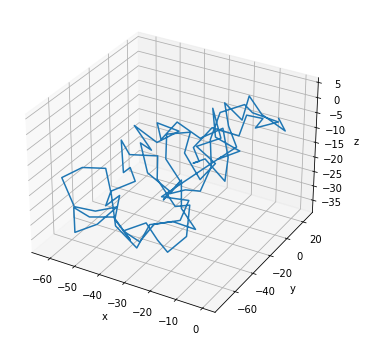

In [7]:
x = polymer.r[:, 0]
y = polymer.r[:, 1]
z = polymer.r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Define Uniform Density Field

We leverage a field theoretic approach  to model interactions between beads and bound marks. The field tracks the density of the polymer and all marks in cubical voxels of space. To instantiate the field, we need to specify the dimensions of the voxel grid, the confinement, and all polymers and marks contained.

Here we instantiate a field that contains the spherical confinement with voxels of 2000 nm width in the x, y, and z directions. Since we are dealing with a homopolymer, there is no energy contribution by the field; however, the simulation requires that a field be defined, and we use the field to enforce the confinement.

In [8]:
n_bins_x = 100
n_bins_y = n_bins_x
n_bins_z = n_bins_x

x_width = 2 * confine_length
y_width = x_width
z_width = x_width

udf = UniformDensityField(
    polymers = [polymer],
    marks = marks,
    x_width = x_width,
    nx = n_bins_x,
    y_width = y_width,
    ny = n_bins_y,
    z_width = z_width,
    nz = n_bins_z,
    confine_type = confine_type,
    confine_length = confine_length
)

### Specify Simulation

The simulator proposes and evaluates random configurational changes to the polymer; in the case of the homopolymer, moves involve physical transformations to the chain.

##### Move and Bead Amplitudes

There are two ways to tune these configurational changes over the course of the simulation; we can either adjust the magnitude of the selection window for affected beads, or we can adjust the magnitude of the transformation itself. We define a "bead amplitude" to represent the maximum magnitude of the selection window for a move and a "move amplitude" to represent the maximum magnitude of the move's transformation. We restrict the move and bead amplitudes between bounds to ensure that MC moves do not become too large or too small. The bounds of the move and bead amplitudes are dependent on the polymers' sizes and are determined by the `get_amplitude_bounds` method in the `__init__` module of the `mc` directory.

In [9]:
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(
    polymers = [polymer]
)

##### Define MC Moves

Here, we identify exactly which MC moves we wish to include in the simulation. We use the following moves in this. example:

- **Slide:** Translation of a continuous segment of beads in a random direction
- **Crank-Shaft:** Rotation of an internal segment of the polymer about the axis containing the segment
- **End-Pivot:** Rotation of a segment on one end of the polymer about an arbitrary axis
- **Tangent Rotation:** Rotation of the tangent vectors of random beads in the polymer

Since we often use this combination of MC moves, comprising all the physical transformations we've implemented so far, we have defined a helper function called `all_moves_except_binding_state` in the `chromo.mc.mc_controller` module to initialize the moves. The adaptable moves themselves are attributes of controllers that dynamically adjusts the move and bead amplitudes over the course of the simulation. Since each move is associated with a log file that may be used to track its acceptance rate, we need to specify an output directory for the simulation. The `get_unique_subfolder_name` function in the `chromo.util.reproducibility` module identifies a unique output directory name for the simulation.

In [10]:
latest_sim = get_unique_subfolder_name("output/sim_")
moves_to_use = ctrl.all_moves_except_binding_state(
    log_dir=latest_sim,
    polymers=[polymer],
    bead_amp_bounds=amp_bead_bounds.bounds,
    move_amp_bounds=amp_move_bounds.bounds,
    controller=ctrl.SimpleControl
)

##### Simulation Length

We define the simulation by the number of snapshots we would like to generate and the number of iterations of each move between the snapshots. Here, we specify a simulation producing 100 snapshots, each with 40,000 iterations of each MC move.

In [11]:
num_snapshots = 100
mc_steps_per_snapshot = 40000

### Run the Simulation

The `polymer_in_field` method defined in the `__init__` file of the `mc` directory initiates the simulation. Running the code block below generates a unique output directory and run the simulation.

In [12]:
%%capture
mc.polymer_in_field(
    polymers = [polymer],
    marks = marks,
    field = udf,
    num_save_mc = mc_steps_per_snapshot,
    num_saves = num_snapshots,
    bead_amp_bounds = amp_bead_bounds,
    move_amp_bounds = amp_move_bounds,
    output_dir = 'output',
    mc_move_controllers = moves_to_use
)

### Evaluate Convergence

With the simulation complete, we want to check for energy and configurational convergence in the Monte Carlo snapshots. First we recall the latest simulation output directory. From that directory, we load the polymer configuration in each snapshot. We then evaluate the elastic energy of each bond. We lastly check that the mean squared separation distance between beads $n = 50$ monomers apart on the chain also converges.

##### List Polymer Output Files

Polymer configurations are saved at each snapshot of the simulation in the simulation's output directory. All polymer configurations are saved with `.csv` extension and are prepended with the label `poly_1`. The snapshot number is indicated after a hyphen and before the file extension in the polymer output file name.

In [13]:
# Load names of polymer configuration output files
output_files = os.listdir(latest_sim)
output_files = [
    f for f in output_files if f.endswith(".csv") and f.startswith("poly_1")
]
snapshot = [int(f.split("-")[-1].split(".")[0]) for f in output_files]
sorted_snap = np.sort(np.array(snapshot))
output_files = [f for _, f in sorted(zip(snapshot, output_files))]

##### Calculate Energies

The polymer class has a `compute_E` method for calculating total energy.

In [14]:
all_energies = []
polymer_energies = []

for i, f in enumerate(output_files):
    snap = sorted_snap[i]
    output_path = str(latest_sim) + '/' + f

    r = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[1, 2, 3],
        dtype=float
    ).to_numpy()

    t3 = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[4, 5, 6],
        dtype=float
    ).to_numpy()

    polymer.r = r.copy()
    polymer.t3 = t3.copy()

    polymer_energy = polymer.compute_E()
    polymer_energies.append(polymer_energy)

##### Plot Energy Convergence

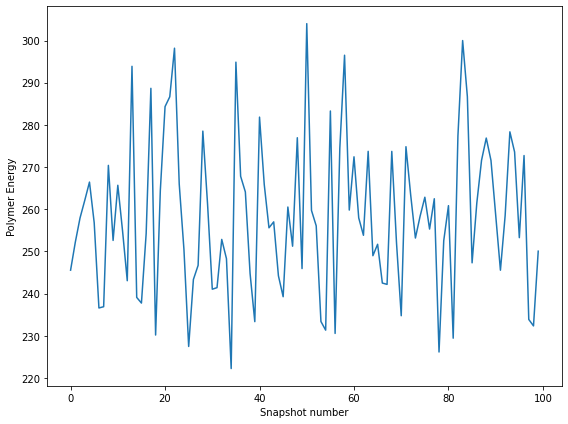

In [15]:
plt.figure(figsize=(8,6))
plt.plot(sorted_snap, polymer_energies)
plt.xlabel("Snapshot number")
plt.ylabel("Polymer Energy")
plt.tight_layout()
plt.show()

##### Calculate MSD

Check that the mean squared separation distance of beads $n = 5$ monomers apart on the chain converges during the simulation. In the `chromo.util.poly_stat` module, there is a method that does this calculation.

In [16]:
delta = 5  # Monomer monomer separation at which to calculate mean squared distance.

all_dists = []
for i, f in enumerate(output_files):
    snap = sorted_snap[i]
    output_path = str(latest_sim) + '/' + f
    r = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[1, 2, 3],
        dtype=float
    ).to_numpy()
    poly_stat = ps.PolyStats(r, lp, "overlap")
    windows = poly_stat.load_indices(delta)
    all_dists.append(poly_stat.calc_r2(windows))

##### Plot MSD Convergence

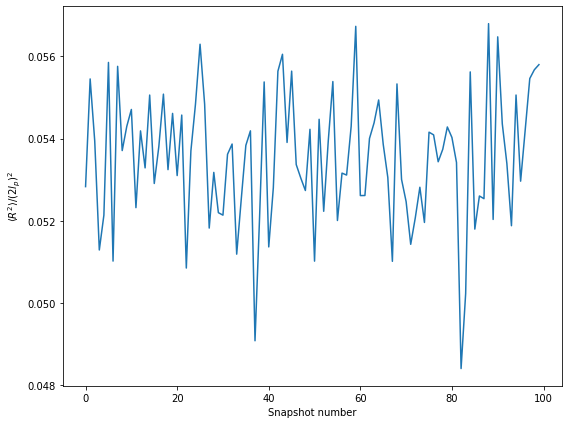

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(sorted_snap, all_dists)
plt.xlabel("Snapshot number")
plt.ylabel(r"$\langle R^2 \rangle /(2l_p)^2$")
plt.tight_layout()
plt.show()

### Plot the Final Snapshot of the Simulation

Since we define a very rigid polymer, we expect the final configuration to take a loose,ring-like shape.

In [19]:
final_snapshot = str(latest_sim) + '/' + output_files[num_snapshots-1]
r = pd.read_csv(
    final_snapshot,
    header=0,
    skiprows=1,
    usecols=[1, 2, 3],
    dtype=float
).to_numpy()

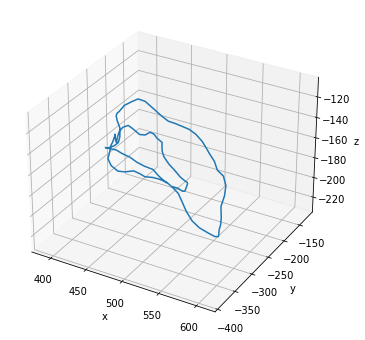

In [20]:
x = r[:, 0]
y = r[:, 1]
z = r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Summary

In this simulation, we defined a rigid, ring-like polymer initialized as a Gaussian random walk, and using a purely physical approach, we sampled one of its relaxed, energetically favorable configurations.